In [1]:
using CSV, Plots, Random, LinearAlgebra, Statistics, DataFrames, ARFIMA, GLM, RDatasets, XGBoost, SparseArrays
include("proxgrad.jl")

proxgrad_const

In [2]:
sentiment = CSV.read("sentiment4.csv")
sentiment = [sentiment[1:6] sentiment[8]]

Walmart = CSV.read("WMT_adjclose.csv")["Price"]
Target = CSV.read("TGT_adjclose.csv")["Price"]
Macy = CSV.read("M_adjclose.csv")["Price"]
Lululemon = CSV.read("LULU_adjclose.csv")["Price"]
Costco = CSV.read("COST_adjclose.csv")["Price"]
Nordstrom = CSV.read("JWN_adjclose.csv")["Price"]
HomeDepot = CSV.read("HD_adjclose.csv")["Price"]
Kohl = CSV.read("KSS_adjclose.csv")["Price"]
JCPenney = CSV.read("JCPNQ_adjclose.csv")["Price"]
Ulta = CSV.read("ULTA_adjclose.csv")["Price"];

In [3]:
function standardize(stock)
    return (stock .- mean(stock))/sqrt(var(stock))
end

function MA(stock)
    ma = stock[1:4]
    for i in 5:length(stock)
        ma = vcat(ma, mean(stock[i-4:i]))
    end
    return ma
end

function abs_err(y,pred)
    return mean(abs.(y-pred))/mean(y)
end

abs_err (generic function with 1 method)

In [4]:
sentiment[1] = standardize(sentiment[1])
sentiment[2] = standardize(sentiment[2])
sentiment[3] = standardize(sentiment[3])
sentiment[4] = standardize(sentiment[4])
sentiment[5] = standardize(sentiment[5])
sentiment[6] = standardize(sentiment[6])
sentiment[7] = standardize(sentiment[7])

Walmart = standardize(Walmart)
Target = standardize(Target)
Macy = standardize(Macy)
Lululemon = standardize(Lululemon)
Costco = standardize(Costco)
Nordstrom = standardize(Nordstrom)
HomeDepot = standardize(HomeDepot)
Kohl = standardize(Kohl)
JCPenney = standardize(JCPenney)
Ulta = standardize(Ulta)

Walmart_MA = MA(Walmart)
Target_MA = MA(Target)
Macy_MA = MA(Macy)
Lululemon_MA = MA(Lululemon)
Costco_MA = MA(Costco)
Nordstrom_MA = MA(Nordstrom)
HomeDepot_MA = MA(HomeDepot)
Kohl_MA = MA(Kohl)
JCPenney_MA = MA(JCPenney)
Ulta_MA = MA(Ulta);

In [5]:
function select_best_model(stock, sentiment)
    # index for 5-fold
    split = [43, 43+44, 43+44*2, 43+44*3, 43+44*4, 43+44*5]
    num_of_model = 3
    mse = zeros(num_of_model,5)
    w = zeros(18)
    for i in 1:5
        w_set = []
        # setting train and validation set
        split_cur = split[i]
        split2 = Int(round(split_cur*4/5))

        stock_train = stock[1:split2]
        stock_val = stock[split2 + 1:split_cur]

        sent_train = sentiment[1][1:split2]
        sent_val = sentiment[1][split2 + 1:split_cur]

        death_train = sentiment[3][1:split2]
        death_val = sentiment[3][split2 + 1:split_cur]

        vac_train = sentiment[2][1:split2]
        vac_val = sentiment[2][split2 + 1:split_cur]

        shut_train = sentiment[4][1:split2]
        shut_val = sentiment[4][split2 + 1:split_cur]

        # Naive Model, w[1:5]
        Xtrain = [sent_train death_train vac_train shut_train ones(length(sent_train))]
        Xval = [sent_val death_val vac_val shut_val ones(length(sent_val))]
        Ytrain = stock_train
        Yval = stock_val

        w_cur = Xtrain\Ytrain
        w_set = vcat(w_set, w_cur)
        pred = Xval*w_cur
        mse[1,i] = abs_err(Yval,pred)

        # AR1 Model, w[6:11]
        Xtrain = [sent_train[2:end] stock_train[1:end-1] death_train[2:end] vac_train[2:end] shut_train[2:end] ones(length(sent_train)-1)]
        Xval = [sent_val[2:end] stock_val[1:end-1] death_val[2:end] vac_val[2:end] shut_val[2:end] ones(length(sent_val)-1)]
        Ytrain = stock_train[2:end]
        Yval = stock_val[2:end]

        w_cur = Xtrain\Ytrain
        w_set = vcat(w_set, w_cur)
        pred = Xval*w_cur
        mse[2,i] = abs_err(Yval,pred)

        # AR2 Model, w[12:18]
        Xtrain = [sent_train[3:end] stock_train[2:end-1] stock_train[1:end-2] death_train[3:end] vac_train[3:end] shut_train[3:end] ones(length(sent_train)-2)]
        Xval = [sent_val[3:end] stock_val[2:end-1] stock_val[1:end-2] death_val[3:end] vac_val[3:end] shut_val[3:end] ones(length(sent_val)-2)]
        Ytrain = stock_train[3:end]
        Yval = stock_val[3:end]

        w_cur = Xtrain\Ytrain
        w_set = vcat(w_set, w_cur)
        pred = Xval*w_cur
        mse[3,i] = abs_err(Yval,pred)
        w = hcat(w,w_set)
    end
    w = w[:,2:6]
    
    avg_mse = mean(mse, dims=2)
    final_model = findmin(avg_mse)[2][1]
    test_mse = zeros(5)
    model = ["Naive Model", "AR1 Model", "AR2 Model"]
    model_length = [5, 6, 7]
    fig = plot(linestyle = :dot, title = "Test Predictions from 9/17 to 10/30")
    w_test = zeros(model_length[final_model])
    
    for i in 1:5
        #Fixed index
        stock_train = stock[1:split[i]]
        sent_train = sentiment[1][1:split[i]]
        death_train = sentiment[3][1:split[i]]
        vac_train = sentiment[2][1:split[i]]
        shut_train = sentiment[4][1:split[i]]

        stock_test = stock[split[i]+1:split[i+1]]
        sent_test = sentiment[1][split[i]+1:split[i+1]]
        death_test = sentiment[3][split[i]+1:split[i+1]]
        vac_test = sentiment[2][split[i]+1:split[i+1]]
        shut_test = sentiment[4][split[i]+1:split[i+1]]

        if final_model == 1   # Naive Model
            Xtrain = [sent_train death_train vac_train shut_train ones(length(sent_train))]
            Xtest = [sent_test death_test vac_test shut_test ones(length(sent_test))]
            Ytrain = stock_train
            Ytest = stock_test

            w_cur = Xtrain\Ytrain
            w_test = hcat(w_test, w_cur)
            pred = Xtest*w_cur
            test_mse[i] = abs_err(Ytest,pred)
            #plot
            if i == 5
                date = [1:44]
                plot!(date, Ytest, color = :red,  label = "Actual Stock Price")
                plot!(date, pred, color = :blue, label = "Naive Model")
            end

        elseif final_model == 2   # AR1 Model
            Xtrain = [sent_train[2:end] stock_train[1:end-1] death_train[2:end] vac_train[2:end] shut_train[2:end] ones(length(stock_train)-1)]
            Xtest = [sent_test[2:end] stock_test[1:end-1] death_test[2:end] vac_test[2:end] shut_test[2:end] ones(length(stock_test)-1)]
            Ytrain = stock_train[2:end]
            Ytest = stock_test[2:end]

            w_cur = Xtrain\Ytrain
            w_test = hcat(w_test, w_cur)
            pred = Xtest*w_cur
            test_mse[i] = abs_err(Ytest,pred)
            #plot
            if i == 5
                date = [2:44]
                plot!(date, Ytest, color = :red,  label = "Actual Stock Price")
                plot!(date, pred, color = :blue, label = "AR1 Model")
            end

        elseif final_model == 3   # AR2 Model
            Xtrain = [sent_train[3:end] stock_train[2:end-1] stock_train[1:end-2] death_train[3:end] vac_train[3:end] shut_train[3:end] ones(length(sent_train)-2)]
            Xtest = [sent_test[3:end] stock_test[2:end-1] stock_test[1:end-2] death_test[3:end] vac_test[3:end] shut_test[3:end] ones(length(stock_test)-2)]
            Ytrain = stock_train[3:end]
            Ytest = stock_test[3:end]

            w_cur = Xtrain\Ytrain
            w_test = hcat(w_test, w_cur)
            pred = Xtest*w_cur
            test_mse[i] = abs_err(Ytest,pred) 
            #plot
            if i == 5
                date = [3:44]
                plot!(date, Ytest, color = :red, label = "Actual Stock Price")
                plot!(date, pred, color = :blue, label = "AR2 Model")
            end
        else
            print("error")
        end  
    end
    w_test = w_test[:,2:6]
    display(fig)
    print("Selected Model: ", model[final_model], "\nEstimated Error: ", mean(test_mse), "\nValidation Error: ", findmin(avg_mse)[1])
end

select_best_model (generic function with 1 method)

In [6]:
function select_best_model_1(stock, sentiment, stockMa)
    # index for 5-fold
    split = [43, 43+44, 43+44*2, 43+44*3, 43+44*4, 43+44*5]
    num_of_model = 2
    mse = zeros(num_of_model*9,5)
    w = zeros(162)
    for i in 1:5
        w_set = []
        position = 1
        # setting train and validation set
        split_cur = split[i]
        split2 = Int(round(split_cur*4/5))

        stock_train = stock[1:split2]
        stock_val = stock[split2 + 1:split_cur]
        
        stockMa_train = stockMa[1:split2]
        stockMa_val = stockMa[split2 + 1:split_cur]

        sent_train = sentiment[1][1:split2]
        sent_val = sentiment[1][split2 + 1:split_cur]

        death_train = sentiment[3][1:split2]
        death_val = sentiment[3][split2 + 1:split_cur]

        vac_train = sentiment[2][1:split2]
        vac_val = sentiment[2][split2 + 1:split_cur]

        shut_train = sentiment[4][1:split2]
        shut_val = sentiment[4][split2 + 1:split_cur]
        
        spred_train = sentiment[5][1:split2]
        spred_val = sentiment[5][split2 + 1:split_cur]
        
        death_train = sentiment[6][1:split2]
        death_val = sentiment[6][split2 + 1:split_cur]
        
        pos_train = sentiment[7][1:split2]
        pos_val = sentiment[7][split2 + 1:split_cur]

        #Naive Model, w[1:9]*9
        Xtrain = [sent_train[2:end] stockMa_train[1:end-1] death_train[2:end] vac_train[2:end] shut_train[2:end] spred_train[2:end] death_train[2:end] pos_train[2:end] ones(length(sent_train)-1)]
        Xval = [sent_val[2:end] stockMa_val[1:end-1] death_val[2:end] vac_val[2:end] shut_val[2:end] spred_val[2:end] death_val[2:end] pos_val[2:end] ones(length(sent_val)-1)]
        Ytrain = stock_train[2:end]
        Yval = stock_val[2:end]
        for j in [0.1:0.1:0.9;]
            n = length(Ytrain)
            loss = 1/n*QuadLoss()

            # we form λ|| ⋅ ||^2 by multiplying the QuadReg() function by λ
            λ = j
            reg = λ*QuadReg()

            w_cur = proxgrad(loss, reg, Xtrain, Ytrain, maxiters=1000)
            w_set = vcat(w_set, w_cur)
            pred = Xval*w_cur

            mse[position,i] = abs_err(Yval,pred)
            position = position + 1
        end

        for j in [0.1:0.1:0.9;]
            n = length(Ytrain)
            loss = 1/n*QuadLoss()

            # we form λ|| ⋅ ||^2 by multiplying the QuadReg() function by λ
            λ = j
            reg = λ*OneReg()

            w_cur = proxgrad(loss, reg, Xtrain, Ytrain, maxiters=1000)
            w_set = vcat(w_set, w_cur)
            pred = Xval*w_cur

            mse[position,i] = abs_err(Yval,pred)
            position = position + 1
        end
        w = hcat(w, w_set)
    end
    return w,mse
end

select_best_model_1 (generic function with 1 method)

In [7]:
function select_best_model_2(stock, sentiment, w, mse, stockMa)
    split = [43, 43+44, 43+44*2, 43+44*3, 43+44*4, 43+44*5]
    avg_mse = mean(mse, dims=2)
    final_model = findmin(avg_mse)[2][1]
    test_mse = zeros(5)
    fig = plot(linestyle = :dot, title = "Test Predictions from 9/17 to 10/30")
    w_test = zeros(9)
        
    for i in 1:5
        #Fixed index
        stock_train = stock[1:split[i]]
        stockMa_train = stockMa[1:split[i]]
        sent_train = sentiment[1][1:split[i]]
        death_train = sentiment[3][1:split[i]]
        vac_train = sentiment[2][1:split[i]]
        shut_train = sentiment[4][1:split[i]]
        spred_train = sentiment[5][1:split[i]]
        death_train = sentiment[6][1:split[i]]
        pos_train = sentiment[7][1:split[i]]
        
        stock_test = stock[split[i]+1:split[i+1]]
        stockMa_test = stockMa[split[i]+1:split[i+1]]
        sent_test = sentiment[1][split[i]+1:split[i+1]]
        death_test = sentiment[3][split[i]+1:split[i+1]]
        vac_test = sentiment[2][split[i]+1:split[i+1]]
        shut_test = sentiment[4][split[i]+1:split[i+1]]
        spred_test = sentiment[5][split[i]+1:split[i+1]]
        death_test = sentiment[6][split[i]+1:split[i+1]]
        pos_test = sentiment[7][split[i]+1:split[i+1]]

        if final_model ÷ 2 == 1
            Xtrain = [sent_train[2:end] stockMa_train[1:end-1] death_train[2:end] vac_train[2:end] shut_train[2:end] spred_train[2:end] death_train[2:end] pos_train[2:end] ones(length(stock_train)-1)]
            Xtest = [sent_test[2:end] stockMa_test[1:end-1] death_test[2:end] vac_test[2:end] shut_test[2:end] spred_test[2:end] death_test[2:end] pos_test[2:end] ones(length(stock_test)-1)]
            Ytrain = stock_train[2:end]
            Ytest = stock_test[2:end]

            n = length(Ytrain)
            loss = 1/n*QuadLoss()

            # we form λ|| ⋅ ||^2 by multiplying the QuadReg() function by λ
            λ = final_model%9
            reg = λ*QuadReg()

            w_cur = proxgrad(loss, reg, Xtrain, Ytrain, maxiters=1000)
            w_test = hcat(w_test, w_cur)
            pred = Xtest*w_cur
            test_mse[i] = abs_err(Ytest,pred)
            
            if i == 5
                date = [2:44]
                plot!(date, Ytest, color = :red,  label = "Actual Stock Price")
                plot!(date, pred, color = :blue, label = "AR1 Model")
            end

        else
            Xtrain = [sent_train[2:end] stockMa_train[1:end-1] death_train[2:end] vac_train[2:end] shut_train[2:end] spred_train[2:end] death_train[2:end] pos_train[2:end] ones(length(stock_train)-1)]
            Xtest = [sent_test[2:end] stockMa_test[1:end-1] death_test[2:end] vac_test[2:end] shut_test[2:end] spred_test[2:end] death_test[2:end] pos_test[2:end] ones(length(stock_test)-1)]
            Ytrain = stock_train[2:end]
            Ytest = stock_test[2:end]

            n = length(Ytrain)
            loss = 1/n*QuadLoss()

            # we form λ|| ⋅ ||^2 by multiplying the QuadReg() function by λ
            λ = final_model%9
            reg = λ*OneReg()

            w_cur = proxgrad(loss, reg, Xtrain, Ytrain, maxiters=1000)
            w_test = hcat(w_test, w_cur)
            pred = Xtest*w_cur
            test_mse[i] = abs_err(Ytest,pred)
            
            if i == 5
                date = [2:44]
                plot!(date, Ytest, color = :red,  label = "Actual Stock Price")
                plot!(date, pred, color = :blue, label = "AR1 Model")
            end
        end
    end
    w_test = w_test[:,2:6]
    xaxis!("Date")
    yaxis!("Standardized Stock Price")
    display(fig)
    print("Selected Model: ", final_model, "\nEstimated Error: ", mean(test_mse), "\nValidation Error: ", findmin(avg_mse)[1])
    return w_test
end

select_best_model_2 (generic function with 1 method)

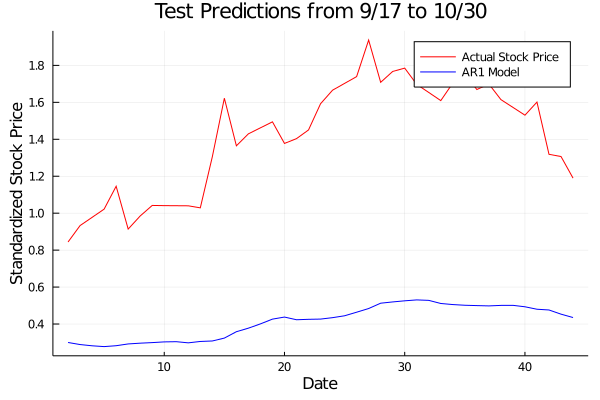

Selected Model: 10
Estimated Error: -1.4305013075087416
Validation Error: 0.051818831207750646

9×5 Array{Float64,2}:
 0.0      0.0       0.0  0.0      0.0
 0.0      0.315348  0.0  0.25658  0.296818
 0.0      0.0       0.0  0.0      0.0
 0.0      0.0       0.0  0.0      0.0
 0.0      0.0       0.0  0.0      0.0
 0.0      0.0       0.0  0.0      0.0
 0.0      0.0       0.0  0.0      0.0
 0.64942  0.193526  0.0  0.0      0.0
 0.0      0.0       0.0  0.0      0.0

In [8]:
# Walmart
w,mse = select_best_model_1(Walmart, sentiment, Walmart_MA)
select_best_model_2(Walmart, sentiment, w, mse, Walmart_MA)

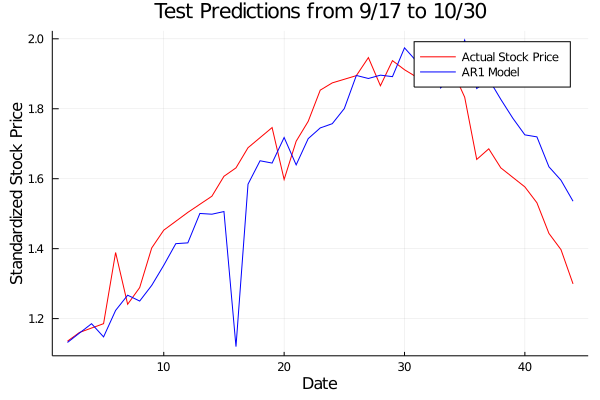

Selected Model: 18
Estimated Error: -0.12272463196880867
Validation Error: -0.4421498381897333

9×5 Array{Float64,2}:
 -0.230238    -0.0318852   -0.0258386   -0.0161845   -0.0365683
  1.04025      0.898395     0.881518     0.895287     0.93756
  0.00619406  -0.00739845  -0.00717206  -0.00358545   0.0016653
 -0.0210142   -0.0463896   -0.0327365   -0.0266723   -0.00759966
 -0.0385512    0.0172653    0.0165104    0.0210742    0.0129399
 -0.0399294   -0.01532     -0.0106642   -0.0107686   -0.0138578
  0.00619406  -0.00739845  -0.00717206  -0.00358545   0.0016653
  0.026567     0.102739     0.105525     0.0927758    0.0918929
 -0.0150015   -0.00773149  -0.0129672   -0.0141836    0.0206388

In [9]:
# Target
w,mse = select_best_model_1(Target, sentiment, Target_MA)
select_best_model_2(Target, sentiment, w, mse, Target_MA)

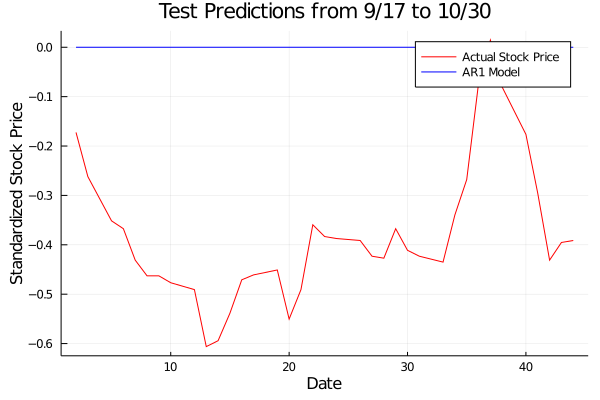

Selected Model: 8
Estimated Error: -1.3111876152474153
Validation Error: -0.20903915618897823

9×5 Array{Float64,2}:
 0.0       0.0  0.0  0.0  0.0
 0.205323  0.0  0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0

In [10]:
# Macy
w,mse = select_best_model_1(Macy, sentiment, Macy_MA)
select_best_model_2(Macy, sentiment, w, mse, Macy_MA)

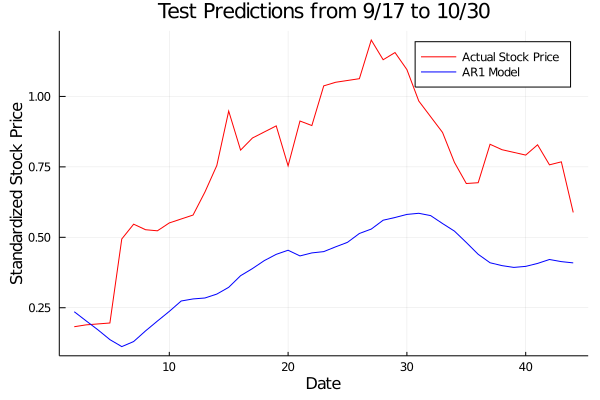

Selected Model: 10
Estimated Error: 1.0006218275751801
Validation Error: 0.07544090222716507

9×5 Array{Float64,2}:
 0.0        0.0       0.0       0.0       0.0
 0.645272   0.703586  0.574714  0.474404  0.518431
 0.0        0.0       0.0       0.0       0.0
 0.0        0.0       0.0       0.0       0.0
 0.0        0.0       0.0       0.0       0.0
 0.0        0.0       0.0       0.0       0.0
 0.0        0.0       0.0       0.0       0.0
 0.0895178  0.0       0.0       0.0       0.0
 0.0        0.0       0.0       0.0       0.0

In [11]:
# Lululemon
w,mse = select_best_model_1(Lululemon, sentiment, Lululemon_MA)
select_best_model_2(Lululemon, sentiment, w, mse, Lululemon_MA)

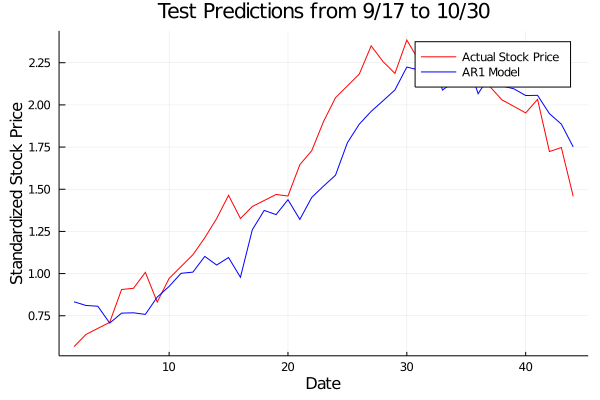

Selected Model: 9
Estimated Error: -0.38990197131938303
Validation Error: 4.603780386876738

9×5 Array{Float64,2}:
 -0.308778     0.00717585  -0.0028946   0.0233974   -0.00248749
  0.66604      0.641742     0.686385    0.857596     0.90493
  0.00671616  -0.00800989  -0.0121785  -0.00345012  -0.00602283
 -0.105136    -0.141598    -0.0927737  -0.0718995   -0.0406682
 -0.0968802   -0.00109235   0.0165993   0.0259326    0.0229262
 -0.149819    -0.0511328   -0.0389245  -0.0138411   -0.0121726
  0.00671616  -0.00800989  -0.0121785  -0.00345012  -0.00602283
  0.174207     0.155199     0.0277058   0.0928382    0.0970151
 -0.129878    -0.113278    -0.238621   -0.0356659    0.00704084

In [12]:
# Costco
w,mse = select_best_model_1(Costco, sentiment, Costco_MA)
select_best_model_2(Costco, sentiment, w, mse, Costco_MA)

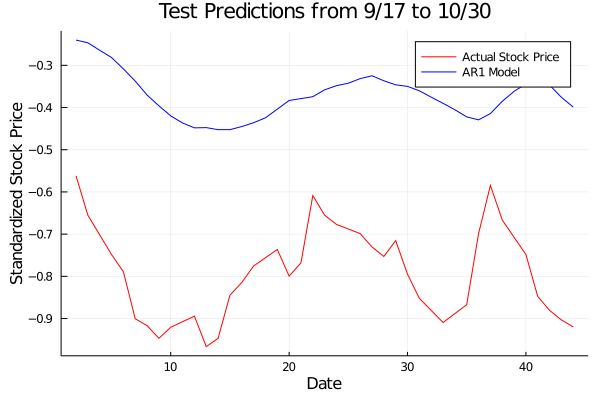

Selected Model: 1
Estimated Error: -1.5130797627853128
Validation Error: -4.681287910422051

9×5 Array{Float64,2}:
 0.0       0.0       0.0       0.0       0.0
 0.835375  0.737679  0.642811  0.565831  0.48802
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0

In [13]:
# Nordstrom
w,mse = select_best_model_1(Nordstrom, sentiment, Nordstrom_MA)
select_best_model_2(Nordstrom, sentiment, w, mse, Nordstrom_MA)

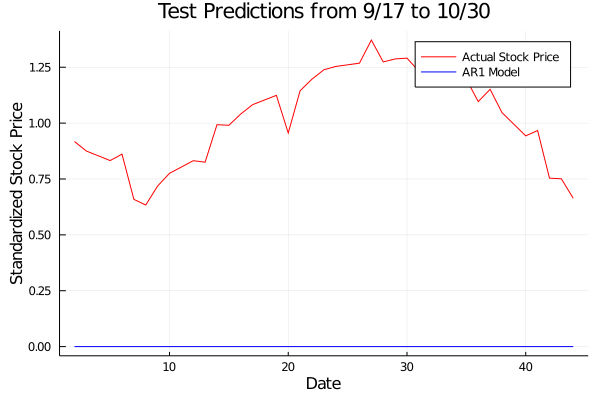

Selected Model: 14
Estimated Error: -0.2533374098851935
Validation Error: 0.278142773138483

9×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [14]:
# HomeDepot
w,mse = select_best_model_1(HomeDepot, sentiment, HomeDepot_MA)
select_best_model_2(HomeDepot, sentiment, w, mse, HomeDepot_MA)

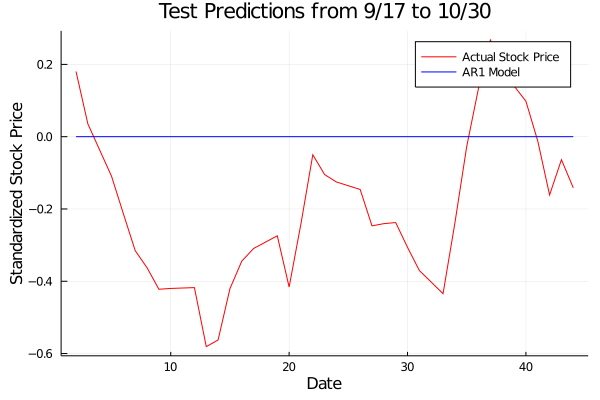

Selected Model: 8
Estimated Error: -1.6592804656402644
Validation Error: -0.6562193244946274

9×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [15]:
# Kohl
w,mse = select_best_model_1(Kohl, sentiment, Kohl_MA)
select_best_model_2(Kohl, sentiment, w, mse, Kohl_MA)

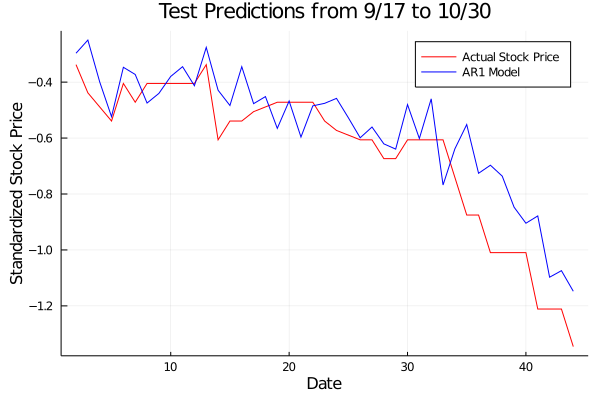

Selected Model: 9
Estimated Error: -0.6087517471477947
Validation Error: -2.083988376881298

9×5 Array{Float64,2}:
 -0.304185   -0.018373    0.0155337    0.0263708    0.0442807
  0.858533    0.894446    0.901616     0.896195     0.902846
 -0.0219271  -0.0183453  -0.0111539   -0.00940252   0.000325786
  0.0397372  -0.0120601  -0.0638527   -0.0541465   -0.0638984
 -0.180247   -0.0412051  -0.00428569  -0.00684146  -0.00819921
 -0.0663859  -0.0391872  -0.0812132   -0.0746972   -0.0609362
 -0.0219271  -0.0183453  -0.0111539   -0.00940252   0.000325786
 -0.0357811  -0.163065   -0.0294792   -0.0380192   -0.0219729
  0.0275651  -0.181793   -0.0285207   -0.0309179   -0.0262274

In [16]:
# JCPenney
w,mse = select_best_model_1(JCPenney, sentiment, JCPenney_MA)
select_best_model_2(JCPenney, sentiment, w, mse, JCPenney_MA)

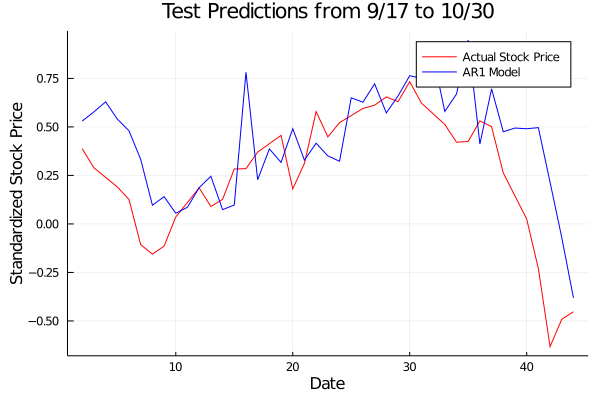

Selected Model: 9
Estimated Error: 0.4858681888062886
Validation Error: -0.07476747489372268

9×5 Array{Float64,2}:
  0.0965139   0.123614    0.0967576    0.104856    0.0959933
  0.940062    0.885105    0.887521     0.917553    0.949147
 -0.133537   -0.0970324  -0.0746963   -0.0590853  -0.0386525
 -0.113777   -0.130826   -0.136808    -0.111218   -0.083372
  0.269207    0.134026    0.136687     0.144245    0.137117
 -0.0346896   0.0118817  -0.019419    -0.0104049   0.00910396
 -0.133537   -0.0970324  -0.0746963   -0.0590853  -0.0386525
  0.0821473   0.170591    0.0764303    0.0303416   0.0971792
 -0.0256181   0.138454    0.00265007  -0.0593342  -0.00727108

In [17]:
# Ulta
w,mse = select_best_model_1(Ulta, sentiment, Ulta_MA)
select_best_model_2(Ulta, sentiment, w, mse, Ulta_MA)

In [18]:
function find_lambda_1(stock, stock_MA, fig, label1)
    i=5
    split = [43, 43+44, 43+44*2, 43+44*3, 43+44*4, 43+44*5]
    stock_train = stock[1:split[i]]
    sent_train = sentiment[1][1:split[i]]
    death_train = sentiment[3][1:split[i]]
    vac_train = sentiment[2][1:split[i]]
    shut_train = sentiment[4][1:split[i]]
    spred_train = sentiment[5][1:split[i]]
    death_train = sentiment[6][1:split[i]]
    pos_train = sentiment[7][1:split[i]]
    stock_MA_train = stock_MA[1:split[i]-4]

    stock_test = stock[split[i]+1:split[i+1]]
    sent_test = sentiment[1][split[i]+1:split[i+1]]
    death_test = sentiment[3][split[i]+1:split[i+1]]
    vac_test = sentiment[2][split[i]+1:split[i+1]]
    shut_test = sentiment[4][split[i]+1:split[i+1]]
    spred_test = sentiment[5][split[i]+1:split[i+1]]
    death_test = sentiment[6][split[i]+1:split[i+1]]
    pos_test = sentiment[7][split[i]+1:split[i+1]]
    stock_MA_test = stock_MA[split[i]-4:split[i+1]-4]

    Xtrain = [sent_train[5:end] stock_MA_train death_train[5:end] vac_train[5:end] shut_train[5:end] spred_train[5:end] death_train[5:end] pos_train[5:end] ones(length(sent_train[5:end]))]
    Xtest = [sent_test[5:end] stock_MA_test[6:end] death_test[5:end] vac_test[5:end] shut_test[5:end] spred_test[5:end] death_test[5:end] pos_test[5:end] ones(length(sent_test[5:end]))]
    Ytrain = stock_train[5:end]
    Ytest = stock_test[5:end]
    # Ridge regression
    abs_er = []
    for i in [0.1:0.1:0.9;]
        n = length(Ytrain)
        loss = 1/n*QuadLoss()

        # we form λ|| ⋅ ||^2 by multiplying the QuadReg() function by λ
        λ = i
        reg = λ*QuadReg()
        w_cur = proxgrad(loss, reg, Xtrain, Ytrain, maxiters=1000)
        pred = Xtest*w_cur
        abs_er = vcat(abs_er, abs_err(Ytest,pred))
    end
    plot!([0.1:0.1:0.9;], abs_er, label = label1)
end

find_lambda_1 (generic function with 1 method)

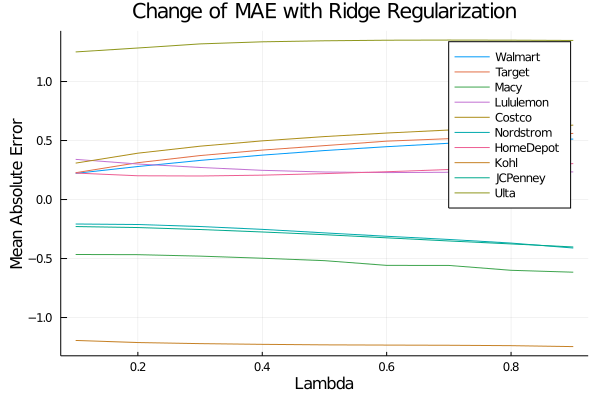

In [19]:
fig = plot(linestyle = :dot, title = "Change of MAE with Ridge Regularization")
find_lambda_1(Walmart, Walmart_MA, fig, "Walmart")
find_lambda_1(Target, Target_MA, fig, "Target")
find_lambda_1(Macy, Macy_MA, fig, "Macy")
find_lambda_1(Lululemon, Lululemon_MA, fig, "Lululemon")
find_lambda_1(Costco, Costco_MA, fig, "Costco")
find_lambda_1(Nordstrom, Nordstrom_MA, fig, "Nordstrom")
find_lambda_1(HomeDepot, HomeDepot_MA, fig, "HomeDepot")
find_lambda_1(Kohl, Kohl_MA, fig, "Kohl")
find_lambda_1(JCPenney, JCPenney_MA, fig, "JCPenney")
find_lambda_1(Ulta, Ulta_MA, fig, "Ulta")
xaxis!("Lambda")
yaxis!("Mean Absolute Error")

In [20]:
function find_lambda_2(stock, stock_MA, fig, label1)
    i=5
    split = [43, 43+44, 43+44*2, 43+44*3, 43+44*4, 43+44*5]
    stock_train = stock[1:split[i]]
    sent_train = sentiment[1][1:split[i]]
    death_train = sentiment[3][1:split[i]]
    vac_train = sentiment[2][1:split[i]]
    shut_train = sentiment[4][1:split[i]]
    spred_train = sentiment[5][1:split[i]]
    death_train = sentiment[6][1:split[i]]
    pos_train = sentiment[7][1:split[i]]
    stock_MA_train = stock_MA[1:split[i]-4]

    stock_test = stock[split[i]+1:split[i+1]]
    sent_test = sentiment[1][split[i]+1:split[i+1]]
    death_test = sentiment[3][split[i]+1:split[i+1]]
    vac_test = sentiment[2][split[i]+1:split[i+1]]
    shut_test = sentiment[4][split[i]+1:split[i+1]]
    spred_test = sentiment[5][split[i]+1:split[i+1]]
    death_test = sentiment[6][split[i]+1:split[i+1]]
    pos_test = sentiment[7][split[i]+1:split[i+1]]
    stock_MA_test = stock_MA[split[i]-4:split[i+1]-4]

    Xtrain = [sent_train[5:end] stock_MA_train death_train[5:end] vac_train[5:end] shut_train[5:end] spred_train[5:end] death_train[5:end] pos_train[5:end] ones(length(sent_train[5:end]))]
    Xtest = [sent_test[5:end] stock_MA_test[6:end] death_test[5:end] vac_test[5:end] shut_test[5:end] spred_test[5:end] death_test[5:end] pos_test[5:end] ones(length(sent_test[5:end]))]
    Ytrain = stock_train[5:end]
    Ytest = stock_test[5:end]
    # Lasso regression
    abs_er = []
    for i in [0.1:0.1:0.9;]
        n = length(Ytrain)
        loss = 1/n*QuadLoss()

        # we form λ|| ⋅ ||^2 by multiplying the QuadReg() function by λ
        λ = i
        reg = λ*OneReg()
        w_cur = proxgrad(loss, reg, Xtrain, Ytrain, maxiters=1000)
        pred = Xtest*w_cur
        abs_er = vcat(abs_er, abs_err(Ytest,pred))
    end
    plot!([0.1:0.1:0.9;], abs_er, label = label1)
end

find_lambda_2 (generic function with 1 method)

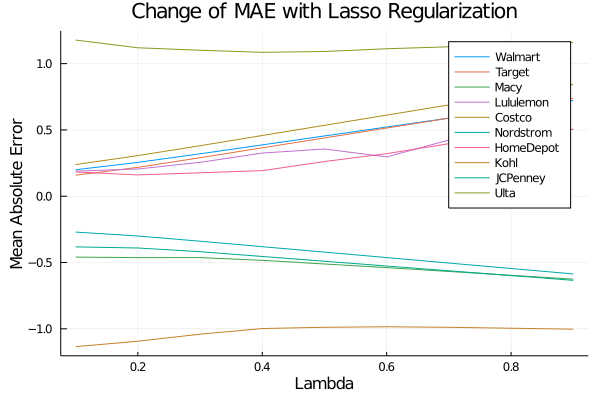

In [21]:
fig = plot(linestyle = :dot, title = "Change of MAE with Lasso Regularization")
find_lambda_2(Walmart, Walmart_MA, fig, "Walmart")
find_lambda_2(Target, Target_MA, fig, "Target")
find_lambda_2(Macy, Macy_MA, fig, "Macy")
find_lambda_2(Lululemon, Lululemon_MA, fig, "Lululemon")
find_lambda_2(Costco, Costco_MA, fig, "Costco")
find_lambda_2(Nordstrom, Nordstrom_MA, fig, "Nordstrom")
find_lambda_2(HomeDepot, HomeDepot_MA, fig, "HomeDepot")
find_lambda_2(Kohl, Kohl_MA, fig, "Kohl")
find_lambda_2(JCPenney, JCPenney_MA, fig, "JCPenney")
find_lambda_2(Ulta, Ulta_MA, fig, "Ulta")
xaxis!("Lambda")
yaxis!("Mean Absolute Error")